In [1]:
from utils.dataset import set_b_dataset
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import librosa
import scipy
import librosa.display
from torch.utils.data import Dataset

PROJECT_DIR = '/Users/nattapolchanpaisit/Documents/GitHub/Algorithm/SC1015-PROJECT/'
data_a_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_a.csv')
data_b_path = pd.read_csv(f'{PROJECT_DIR}dataset/set_b.csv')
data_a_timing = pd.read_csv(f'{PROJECT_DIR}dataset/set_a_timing.csv')

dataset = set_b_dataset(PROJECT_DIR)

## Exploratory data analysis

(0.0, 30.0)

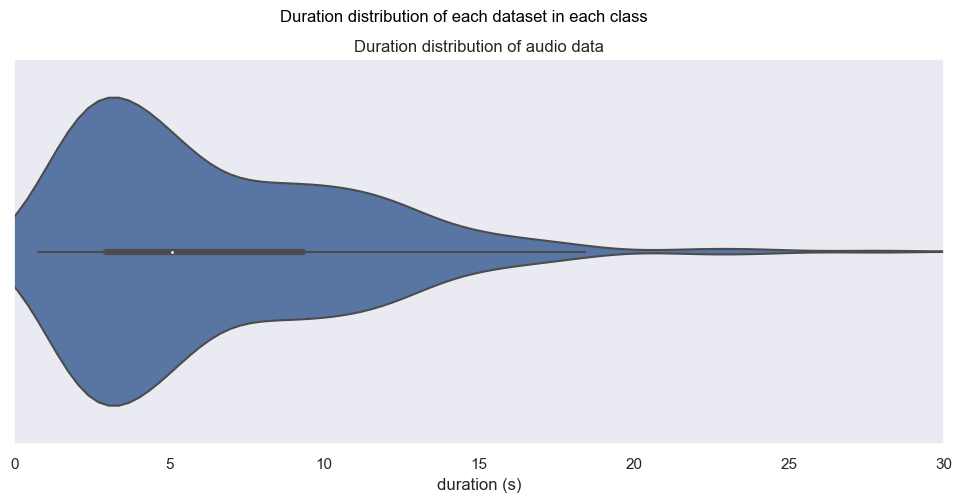

In [2]:
fig = plt.figure(figsize=(12,5))
fig.tight_layout(w_pad=3.0)
fig.suptitle('Duration distribution of each dataset in each class')
sb.set_theme(style="dark")
plt.title('Duration distribution of audio data')
sb.violinplot(dataset.metadata, x='duration', bins=50)
plt.xlabel('duration (s)')
plt.xlim([0,30])


(0.0, 2000.0)

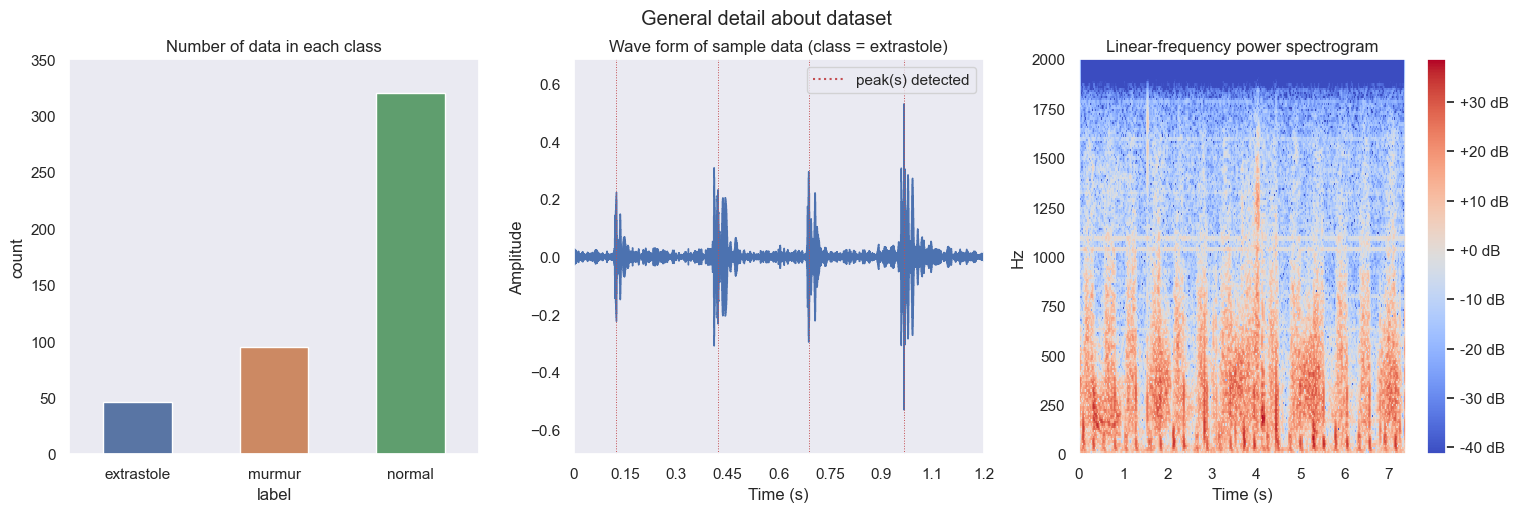

In [3]:
index = 10
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(w_pad=3.0)
fig.suptitle('General detail about dataset')
sb.set_theme(style="dark")
plt.subplots_adjust(top=0.88)
sb.countplot(data_b_path, ax=axes[0], x='label', width=0.5)

librosa.util.peak_pick

# plot number of dataset for each class
axes[0].set_title('Number of data in each class')
axes[0].set_ylim([0, 350])

# plot wave form and peak
peak_array, _ = scipy.signal.find_peaks(dataset.dataset[index], 
                                        height=0.1, distance=0.2*dataset.SR)
dataset.show_wave(index, ax=axes[1])
label = dataset.metadata['label'][index]
for eachpeak in peak_array:
    axes[1].axvline(x = eachpeak/dataset.SR, color = 'r', 
                    ls=":", linewidth=0.7)
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (s)')
dummy_line = axes[1].plot([0,0.000001], [0, 0.00001], color='r', ls=':')
axes[1].set_xlim([0.0, 1.2])
axes[1].set_title(f'Wave form of sample data (class = {label})')
axes[1].legend(dummy_line, ["peak(s) detected"], loc='upper right')

spectrogram = dataset.show_spec(100, ax=axes[2], y_axis='linear', x_axis='time')
fig.colorbar(spectrogram, format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylim([0, 2000])

Note: dB shown in the graph is relative to mean of power (not relative to $10^{-12}$ watt per square metre).

Notice: 
1. number of data in class **'normal'** is a lot more than **'murmur'** and **'extrastole'**. This may cause class imbalance when training the model later, if the dataset is not fed carefully.
2. In the spectrogram (the leftmost figure), there are constant fringe ~0 dB on *Frequency~1000 Hz & ~1100 Hz*. This may be the static noise of the environment/device.

Denoise static frequency

In [4]:
def fft_denoiser(x, n_components, to_real=True):
    n = len(x)
    fft = np.fft.fft(x, n)
    PSD = fft * np.conj(fft) / n
    _mask = PSD > n_components
    fft = _mask * fft
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    
    return clean_data

/Users/nattapolchanpaisit/miniforge3/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


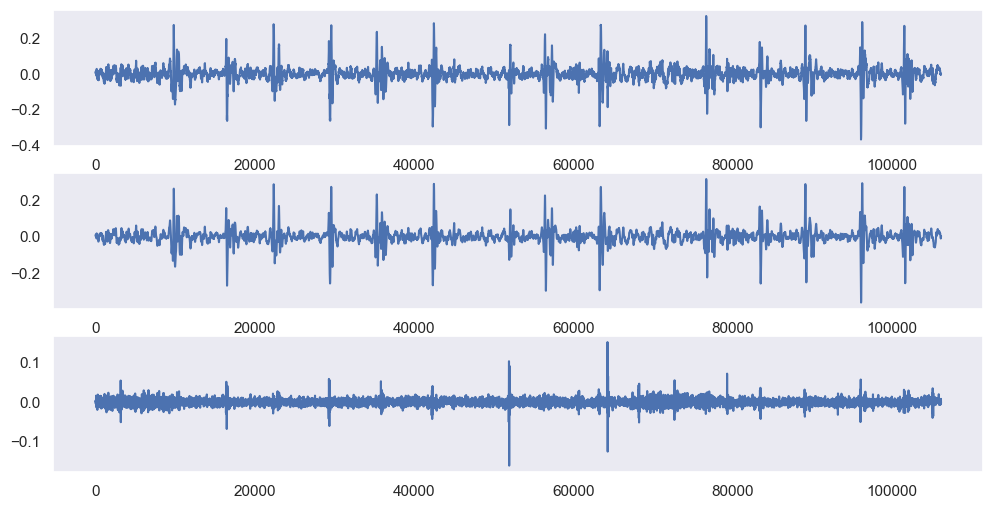

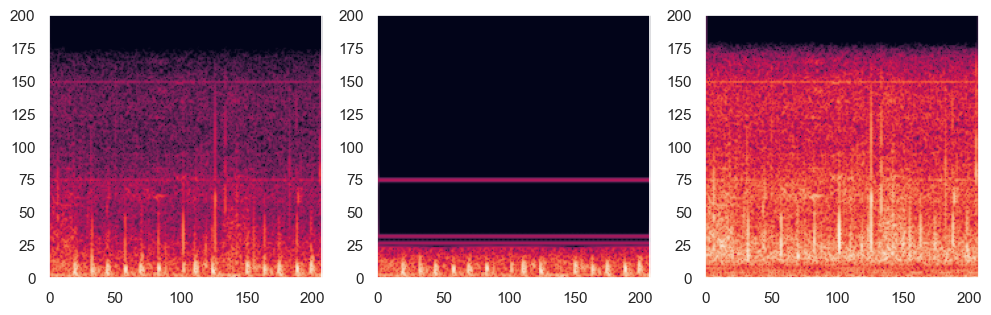

In [6]:
index = 150
noised_data = fft_denoiser(dataset.dataset[index], 0.01)
stft = librosa.amplitude_to_db(librosa.stft(dataset.dataset[index]))
denoised_stft = librosa.amplitude_to_db(librosa.stft(dataset.dataset[index]-noised_data))
noise_stft = librosa.amplitude_to_db(librosa.stft(noised_data))
fig, axes = plt.subplots(3,1,figsize=(12,6))
axes[0].plot(dataset.dataset[index])
axes[1].plot(noised_data)
axes[2].plot(dataset.dataset[index]-noised_data)

plt.show()
fig, axes = plt.subplots(1,3,figsize=(12,6))
axes[0].imshow(stft)
axes[0].set_ylim([0,200])
axes[1].imshow(noise_stft)
axes[1].set_ylim([0,200])
axes[2].imshow(denoised_stft)
axes[2].set_ylim([0,200])
plt.show()

In [7]:
dataset.metadata

,dataset,fname,label,sublabel,bpm,peak-interval,peak-interval-timer
0,b,set_b/extrastole__127_1306764300147_C2.wav,extrastole,NaN,96.235913,"[0.2686167800453515, 0.352562358276644, 0.2744...","[0.1781859410430839, 0.4468027210884354, 0.799..."
1,b,set_b/extrastole__128_1306344005749_A.wav,extrastole,NaN,90.943461,"[0.2494331065759637, 0.37750566893424037, 0.25...","[0.2770068027210884, 0.5264399092970522, 0.903..."
2,b,set_b/extrastole__130_1306347376079_D.wav,extrastole,NaN,112.422248,"[0.2529251700680272, 0.26702947845804986, 0.25...","[0.15156462585034014, 0.40448979591836737, 0.6..."
3,b,set_b/extrastole__134_1306428161797_C1.wav,extrastole,NaN,105.416460,"[0.3017233560090703, 0.28122448979591835, 0.30...","[0.07968253968253969, 0.38140589569161, 0.6626..."
4,b,set_b/extrastole__138_1306762146980_B.wav,extrastole,NaN,74.039667,"[0.28834467120181406, 0.3871201814058957, 0.29...","[0.3514285714285714, 0.6397732426303855, 1.026..."
...,...,...,...,...,...,...,...
456,b,set_b/normal_noisynormal_284_1311168471850_A.wav,normal,noisynormal,96.614187,"[0.3818140589569161, 0.26099773242630386, 0.53...","[0.1110204081632653, 0.4928344671201814, 0.753..."
457,b,set_b/normal_noisynormal_284_1311168471850_B.wav,normal,noisynormal,99.657263,"[0.34607709750566895, 0.2582312925170068, 0.36...","[0.14331065759637188, 0.4893877551020408, 0.74..."
458,b,set_b/normal_noisynormal_285_1311169246969_C.wav,normal,noisynormal,68.588638,"[0.29931972789115646, 0.5092517006802721, 0.29...","[0.2965532879818594, 0.5958730158730159, 1.105..."
459,b,set_b/normal_noisynormal_296_1311682952647_C.wav,normal,noisynormal,118.700977,"[0.28086167800453515, 0.26988662131519275, 0.3...","[0.22136054421768708, 0.5022222222222222, 0.77..."


### 2. Beat per minute distribution across different class

Beat per minute is calculated in function ```aproximate_bpm``` in ```utils.dataset```. 
###### The beats (peaks) are detected using ```scipy.signal.find_peaks``` then the interval between each peak is used to calculate BPM.

Text(0.5, 0.98, 'Distribution of Beat Per Minute (BPM) for each class')

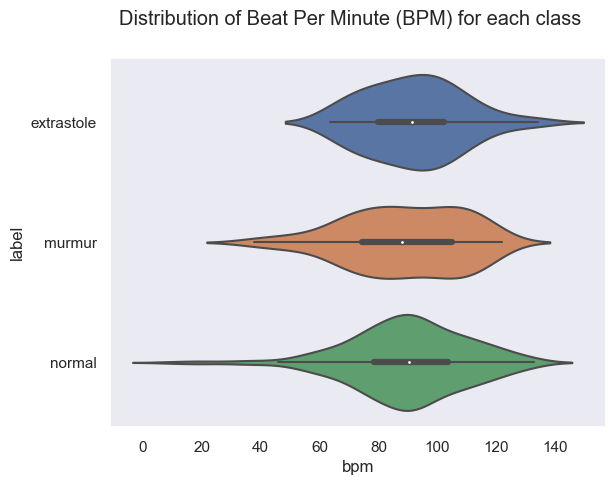

In [8]:
sb.violinplot(data=dataset.metadata, x="bpm", y="label")
plt.plot()
plt.suptitle('Distribution of Beat Per Minute (BPM) for each class')

All 3 class have similar distribution in BPM. Hence, BPM alone may not be a good predictor for classify each heart desease.

## 3. Heart rate variability

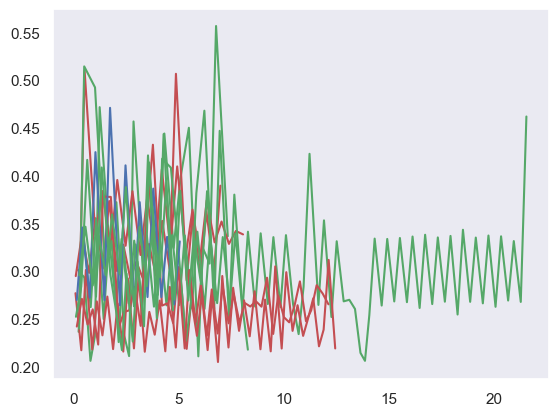

In [29]:
# fig, axes = plt.subplots(5,5, figsize=(10, 10))
# fig.tight_layout(w_pad=1.0)
# fig.suptitle('Plot of HRV')
# sb.set_theme(style="dark")
# plt.subplots_adjust(top=0.95)
for i in range(10):
    index = np.random.randint(len(dataset)-1)
    while dataset.metadata['duration'][index] < 5 or np.amax(dataset.metadata['peak-interval'][index]) > 1.5:
        index = np.random.randint(len(dataset)-1)
    color = 'b'
    if dataset.metadata['label'][index] == 'murmur':
        color = 'r'
    elif dataset.metadata['label'][index] == 'normal':
        color = 'g'
    plt.plot(dataset.metadata['peak-interval-timer'][index], dataset.metadata['peak-interval'][index], color)
    # loop = 0
    # label = dataset.metadata['label'][index]
    # axes[i//5, i%5].plot(dataset.metadata['peak-interval-timer'][index], dataset.metadata['peak-interval'][index])
    # axes[i//5, i%5].set_title(f'{label}')
    # axes[i//5, i%5].set_xlim([0,5])

In [94]:
dataset.metadata['duration'][10]

6.464036281179139

In [99]:
print(len(dataset.dataset[10]))
print(dataset.SR)

142532
22050


In [30]:
import torch
fft_torch = torch.Tensor(dataset.stft[10])
high_freq = 400
low_freq = 200
fft_torch = fft_torch[low_freq//10:high_freq//10,:]
# random_crop_param = int(np.random.rand() * )

torch.Size([20, 279])


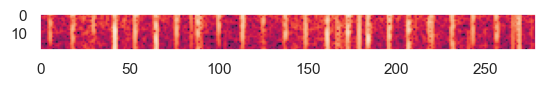

In [34]:
fft, label = dataset.__getitem__(10)
plt.imshow(fft)
print(fft.size())